In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sps
from tqdm import tqdm
from torchinfo import summary # DEBUG

from utils.utils import *
from utils.dataset_loaders import *
from models.basic_models import *

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.io import write_video
from diffusers import UNet3DConditionModel, DDPMScheduler, DDPMPipeline

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

In [9]:
%reload_ext autoreload
%autoreload 2

Creating dataset and dataloader for UCF-101 and MovingMNIST.

In [2]:
# UCF_dataset = UCFDataset("./datasets/UCF-101/")

# batch_size = 1
# UCF_dataloader = DataLoader(UCF_dataset, shuffle=True, batch_size=batch_size)

BATCH_SIZE = 1

# MovMNIST_dataset = MovMNISTDataset("./datasets/moving_mnist.npy")
# MovMNIST_dataloader = DataLoader(MovMNIST_dataset, shuffle=True, batch_size=BATCH_SIZE)

MovMNIST_frame_dataset = MovMNISTFrameDataset("./datasets/moving_mnist.npy")
MovMNIST_frame_dataloader = DataLoader(MovMNIST_frame_dataset, shuffle=True, batch_size=32 * BATCH_SIZE)

In [5]:
model_frame, noise_scheduler_frame, optimizer_frame, lr_scheduler_frame, criterion_frame = init_mov_mnist_model_frame(
    lr_warmup_steps=100,
    num_epochs=3,
    beta_start=1.17e-3,
    beta_end=1.88e-1,
    object_cnt = len(MovMNIST_frame_dataloader),
    device="cpu",
)

model_frame.load_state_dict(torch.load("./models/trained/mov_mnist_frames/model_12500.pt", map_location=torch.device('cpu')))
optimizer_frame.load_state_dict(torch.load("./models/trained/mov_mnist_frames/optimizer_12500.pt", map_location=torch.device('cpu')))
lr_scheduler_frame.load_state_dict(torch.load("./models/trained/mov_mnist_frames/scheduler_12500.pt", map_location=torch.device('cpu')))

In [6]:
callbacker = SimpleSaveCallbacker(
    model_frame,
    optimizer_frame,
    save_path="./models/trained/mov_mnist_frames/",
    lr_scheduler_ref=lr_scheduler_frame,
)
callbacker.save_timer=12500

losses_frames = train_images(
    model=model_frame,
    dataloader=MovMNIST_frame_dataloader,
    noise_scheduler=noise_scheduler_frame,
    criterion=criterion_frame,
    num_epochs=1,
    device="cpu",
    cross_att_dim=4,
    end_processor=callbacker,
)
torch.save(torch.as_tensor(losses_frames), "./models/trained/mov_mnist_frames/losses_frames2.pt")

  0%|          | 2/6250 [00:44<38:12:50, 22.02s/it, MSE=0.0105] 


KeyboardInterrupt: 

In [10]:
model_frame.load_state_dict(torch.load("./models/trained/mov_mnist_frames/model_12500.pt"))

images = sample_images(
    model=model_frame,
    num_images=8,
    noise_scheduler=noise_scheduler_frame,
    device="cuda:0",
    cross_att_dim=4,
).detach().cpu()

images = ((images.clamp(-1, 1) + 1) / 2 * 255).to(torch.uint8)

100%|██████████| 100/100 [00:11<00:00,  8.54it/s]


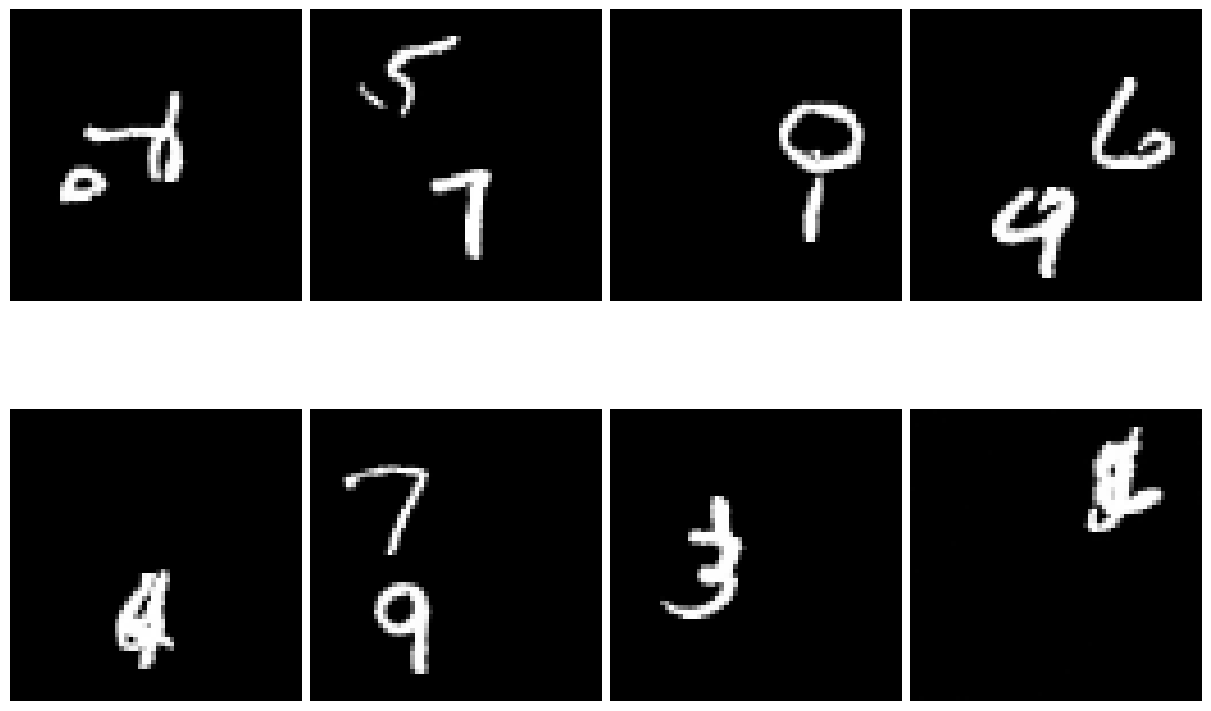

In [14]:
fig, ax = plt.subplots(nrows=2, ncols=4, constrained_layout=True)
fig.set_size_inches(12, 8)

for i, im in enumerate(images):
    ax[i // 4][i % 4].imshow(im.permute(1, 2, 0), cmap="grey")
    ax[i // 4][i % 4].axis("off")

plt.show()

Trying default DDPMScheduler for working with videos.

In [6]:
model, noise_scheduler, optimizer, lr_scheduler, criterion = init_mov_mnist_model(
    lr_warmup_steps=100,
    num_epochs=1,
    beta_start=1.17e-3,
    beta_end=1.88e-1,
    object_cnt = len(MovMNIST_dataloader),
    device="cuda:0"
)

In [4]:
losses_mixed = train_simple_new(
    model=model,
    dataloader=MovMNIST_dataloader,
    noise_scheduler=noise_scheduler,
    optimizer=optimizer,
    lr_scheduler=lr_scheduler,
    criterion=criterion,
    num_epochs=1,
    device="cuda:0",
    noise_cov=mixed_noise,
    cross_att_dim=4,
    save_path="./models/trained/basic_mnist_mixed_noise/"
)

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [7:58:12<00:00,  2.87s/it, MSE=0.000249] 


In [5]:
# try:
#     del model
#     del optimizer
#     del lr_scheduler
# except:
#     pass

# torch.cuda.empty_cache()
# import gc
# gc.collect()

model2, noise_scheduler2, optimizer2, lr_scheduler2, criterion = init_mov_mnist_model(
    lr_warmup_steps=100,
    num_epochs=1,
    beta_start=1.17e-3,
    beta_end=1.88e-1,
    object_cnt = len(MovMNIST_dataloader),
    device="cuda:0"
)

In [6]:
losses_uncorr = train_simple_new(
    model=model2,
    dataloader=MovMNIST_dataloader,
    noise_scheduler=noise_scheduler2,
    optimizer=optimizer2,
    lr_scheduler=lr_scheduler2,
    criterion=criterion,
    num_epochs=1,
    device="cuda:0",
    cross_att_dim=4,
    noise_cov=progressive_noise,
    save_path="./models/trained/basic_mnist_prog_noise/"
)

  0%|          | 1/10000 [00:02<8:16:22,  2.98s/it, MSE=0.999]

100%|██████████| 10000/10000 [8:05:47<00:00,  2.91s/it, MSE=0.00183]  


In [4]:
losses_prog = train_simple_new(
    model=model,
    dataloader=MovMNIST_dataloader,
    noise_scheduler=noise_scheduler,
    optimizer=optimizer,
    lr_scheduler=lr_scheduler,
    criterion=criterion,
    num_epochs=1,
    device="cuda:0",
    noise_cov=progressive_noise,
    cross_att_dim=4,
    save_path="./models/trained/basic_mnist_prog_noise/"
)

100%|██████████| 10000/10000 [8:07:58<00:00,  2.93s/it, MSE=6.19e-5]  


ValueError: too many values to unpack (expected 3)

In [12]:
model.load_state_dict(torch.load("./models/trained/basic_mnist_uncorr_noise/model_best.pt"))

vids = sample_videos(
    model=model,
    num_videos=4,
    video_length=20,
    noise_scheduler=noise_scheduler,
    device="cuda:0",
    pic_size=(64, 64),
    channel_num=1,
    cross_att_dim=4,
    noise_cov=mixed_noise,
    # display_callback=draw_single_vid_frames,
    # sample=sample.unsqueeze(0).cuda(),
).detach().cpu()

vids = ((vids.clamp(-1, 1) + 1) * 255 / 2).to(torch.uint8)

100%|██████████| 100/100 [04:22<00:00,  2.62s/it]


In [30]:
for i, v in enumerate((MovMNIST_dataset[:4][0] + 1) / 2 * 255):
    write_video(f"./results/MovMNIST/base_samples/{i}.mp4", v.to(torch.uint8).repeat(3, 1, 1, 1).permute(1, 2, 3, 0), fps=7)

In [36]:
# noise_gen = NormalVideoNoise(cov_matrix = progressive_noise(20))
# prompts = sin(arange(1, 20 + 1, device="cuda:0").view(-1, 1) * arange(1, 4 + 1, device="cuda:0")).tile(1).view(1, 20, -1)
# sample = noise_gen.sample((1, 1, 20, 64, 64)).to("cuda:0")
# residual = model(sample, 99, prompts).sample[0].detach().cpu()
# residual = ((residual.clamp(-1, 1) + 1) * 255 / 2).to(torch.uint8)

write_video(f"./results/MovMNIST/progressive_noise/test.mp4", sample.repeat(3, 1, 1, 1).permute(1, 2, 3, 0), 7)

In [3]:
# torch.backends.cuda.enable_mem_efficient_sdp(False)
# torch.backends.cuda.enable_flash_sdp(False)
# torch.backends.cuda.enable_math_sdp(False)

summary(
    model,
    input_data = {
        "sample": torch.randn(1, 3, 75, 240, 320),
        "timestep": 500,
        "encoder_hidden_states": torch.ones(1, 75, 24) * 3.0,
    }
)

Layer (type:depth-idx)                                                      Output Shape              Param #
UNet3DConditionModel                                                        [1, 3, 75, 240, 320]      --
├─Timesteps: 1-1                                                            [1, 12]                   --
├─TimestepEmbedding: 1-2                                                    [1, 48]                   2,352
│    └─LoRACompatibleLinear: 2-1                                            [1, 48]                   624
├─SiLU: 1-3                                                                 [1, 48]                   --
├─TimestepEmbedding: 1-4                                                    --                        (recursive)
│    └─LoRACompatibleLinear: 2-2                                            [1, 48]                   2,352
├─Conv2d: 1-5                                                               [75, 12, 240, 320]        336
├─TransformerTemporalModel: 1-6  